# NYC Traffic Collision Analysis - Explainer Notebook

## 1. Motivation

### Dataset Overview
The dataset we're working with is the NYC Motor Vehicle Collisions dataset, which contains detailed information about traffic accidents in New York City. This dataset is particularly interesting because:
- It provides real-world insights into urban traffic safety
- Contains rich temporal and spatial data
- Includes various contributing factors to accidents

### Why This Dataset?
We chose this dataset because:
1. It's highly relevant to urban planning and public safety
2. Offers opportunities for both spatial and temporal analysis
3. Contains multiple variables that can be analyzed for patterns and correlations

### End User Experience Goals
Our goal is to create an interactive visualization that helps users:
- Understand patterns in traffic collisions
- Identify high-risk areas and times
- Explore contributing factors to accidents
- Make data-driven decisions about traffic safety

## 2. Data Processing Pipeline

### 2.1 Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import folium
from folium.plugins import HeatMap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os

# Set style for better visualizations
plt.style.use('ggplot')  # Using a valid style
sns.set_palette('husl')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

### 2.2 Data Loading and Initial Exploration

In [2]:
# Load the full dataset
print("Loading the dataset...")
df = pd.read_csv('../Motor_Vehicle_Collisions_-_Crashes_20250512.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns:")
for col in df.columns:
    print(f"- {col}")

# Display first few rows
display(df.head())


Loading the dataset...


/var/folders/n3/ls_51qb15vl_g8dm78zst3kw0000gn/T/ipykernel_21639/942991053.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../Motor_Vehicle_Collisions_-_Crashes_20250512.csv')


Dataset Shape: (2174590, 29)

Columns:
- CRASH DATE
- CRASH TIME
- BOROUGH
- ZIP CODE
- LATITUDE
- LONGITUDE
- LOCATION
- ON STREET NAME
- CROSS STREET NAME
- OFF STREET NAME
- NUMBER OF PERSONS INJURED
- NUMBER OF PERSONS KILLED
- NUMBER OF PEDESTRIANS INJURED
- NUMBER OF PEDESTRIANS KILLED
- NUMBER OF CYCLIST INJURED
- NUMBER OF CYCLIST KILLED
- NUMBER OF MOTORIST INJURED
- NUMBER OF MOTORIST KILLED
- CONTRIBUTING FACTOR VEHICLE 1
- CONTRIBUTING FACTOR VEHICLE 2
- CONTRIBUTING FACTOR VEHICLE 3
- CONTRIBUTING FACTOR VEHICLE 4
- CONTRIBUTING FACTOR VEHICLE 5
- COLLISION_ID
- VEHICLE TYPE CODE 1
- VEHICLE TYPE CODE 2
- VEHICLE TYPE CODE 3
- VEHICLE TYPE CODE 4
- VEHICLE TYPE CODE 5


,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/11/2021,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,2.0,0.0,0,0,0,0,2,0,Aggressive Driving/Road Rage,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,03/26/2022,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,1.0,0.0,0,0,0,0,1,0,Pavement Slippery,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
2,11/01/2023,1:29,BROOKLYN,11230.0,40.62179,-73.970024,"(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,1.0,0.0,0,0,0,0,1,0,Unspecified,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
3,06/29/2022,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,09/21/2022,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN


### 2.3 Data Cleaning and Preprocessing

In [3]:
def clean_data(df):
    # Create a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Convert date and time columns to datetime
    df_clean['CRASH DATE'] = pd.to_datetime(df_clean['CRASH DATE'])
    df_clean['CRASH TIME'] = pd.to_datetime(df_clean['CRASH TIME'], format='%H:%M').dt.time
    
    # Create datetime column for easier analysis
    df_clean['CRASH DATETIME'] = df_clean.apply(
        lambda x: datetime.combine(x['CRASH DATE'], x['CRASH TIME']), axis=1
    )
    
    # Extract temporal features
    df_clean['HOUR'] = df_clean['CRASH DATETIME'].dt.hour
    df_clean['DAY_OF_WEEK'] = df_clean['CRASH DATETIME'].dt.day_name()
    df_clean['MONTH'] = df_clean['CRASH DATETIME'].dt.month
    
    # Clean location data
    df_clean['LATITUDE'] = pd.to_numeric(df_clean['LATITUDE'], errors='coerce')
    df_clean['LONGITUDE'] = pd.to_numeric(df_clean['LONGITUDE'], errors='coerce')
    
    # Remove rows with invalid coordinates
    df_clean = df_clean.dropna(subset=['LATITUDE', 'LONGITUDE'])
    
    # Clean numeric columns
    numeric_cols = ['NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                   'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
                   'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
                   'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED']
    
    for col in numeric_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)
    
    return df_clean

# Clean the data
df_clean = clean_data(df)

# Display cleaning results
print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())

Original shape: (2174590, 29)
Cleaned shape: (1934674, 33)

Missing values after cleaning:
CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           469116
ZIP CODE                          469359
LATITUDE                               0
LONGITUDE                              0
LOCATION                               0
ON STREET NAME                    412784
CROSS STREET NAME                 733199
OFF STREET NAME                  1583934
NUMBER OF PERSONS INJURED              0
NUMBER OF PERSONS KILLED               0
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       6892
CONTRIBUTING FACTOR VEHICLE 2     313903
CONTRIBUTING FACTOR VEHICLE 3    1795619
CONTRIBUTING FACTOR VEHICLE 4    1902624
CONTRIB

### 2.4 Feature Engineering

In [4]:
def engineer_features(df):
    # Create a copy
    df_featured = df.copy()
    
    # Calculate total casualties
    df_featured['TOTAL_CASUALTIES'] = (
        df_featured['NUMBER OF PERSONS INJURED'] + 
        df_featured['NUMBER OF PERSONS KILLED']
    )
    
    # Create severity categories
    df_featured['SEVERITY'] = pd.cut(
        df_featured['TOTAL_CASUALTIES'],
        bins=[-1, 0, 1, 3, float('inf')],
        labels=['No Injuries', 'Minor', 'Moderate', 'Severe']
    )
    
    # Create time of day categories with unique labels
    df_featured['TIME_OF_DAY'] = pd.cut(
        df_featured['HOUR'],
        bins=[-1, 5, 11, 16, 20, 23],
        labels=['Early Morning', 'Morning', 'Afternoon', 'Evening', 'Night'],  # Changed first 'Night' to 'Early Morning'
        ordered=False  # Added ordered=False to allow duplicate labels if needed
    )
    
    # Create contributing factors list
    factor_columns = [col for col in df_featured.columns if 'CONTRIBUTING FACTOR' in col]
    df_featured['CONTRIBUTING_FACTORS'] = df_featured[factor_columns].apply(
        lambda x: [f for f in x if pd.notna(f) and f != 'Unspecified'], axis=1
    )
    
    return df_featured

# Apply feature engineering
df_featured = engineer_features(df_clean)

# Display new features
print("New features created:")
display(df_featured[['TOTAL_CASUALTIES', 'SEVERITY', 'TIME_OF_DAY', 'CONTRIBUTING_FACTORS']].head())

New features created:


,TOTAL_CASUALTIES,SEVERITY,TIME_OF_DAY,CONTRIBUTING_FACTORS
2,1.0,Minor,Early Morning,[]
9,0.0,No Injuries,Morning,[]
10,0.0,No Injuries,Morning,[]
12,0.0,No Injuries,Evening,[Passing Too Closely]
13,2.0,Moderate,Morning,[]


### 2.5 Basic Statistics and Analysis

In [5]:
def generate_basic_stats(df):
    stats = {
        'Total Collisions': len(df),
        'Date Range': f"{df['CRASH DATE'].min().date()} to {df['CRASH DATE'].max().date()}",
        'Total Injuries': df['NUMBER OF PERSONS INJURED'].sum(),
        'Total Fatalities': df['NUMBER OF PERSONS KILLED'].sum(),
        'Average Daily Collisions': len(df) / (df['CRASH DATE'].max() - df['CRASH DATE'].min()).days,
        'Most Common Time of Day': df['TIME_OF_DAY'].mode()[0],
        'Most Common Day of Week': df['DAY_OF_WEEK'].mode()[0]
    }
    
    return pd.Series(stats)

# Generate and display basic statistics
basic_stats = generate_basic_stats(df_featured)
print("Basic Statistics:")
for stat, value in basic_stats.items():
    print(f"{stat}: {value}")

Basic Statistics:
Total Collisions: 1934674
Date Range: 2012-07-01 to 2025-05-06
Total Injuries: 627005.0
Total Fatalities: 2950.0
Average Daily Collisions: 412.33461210571187
Most Common Time of Day: Afternoon
Most Common Day of Week: Friday


### 2.6 Temporal Analysis

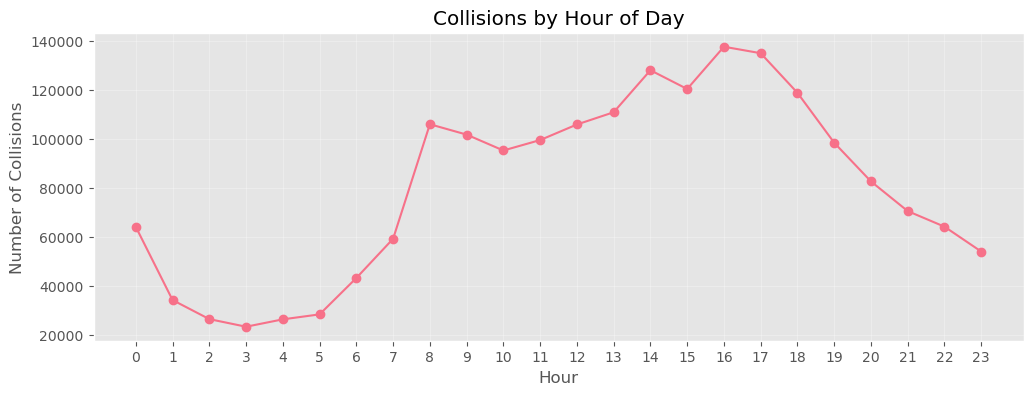

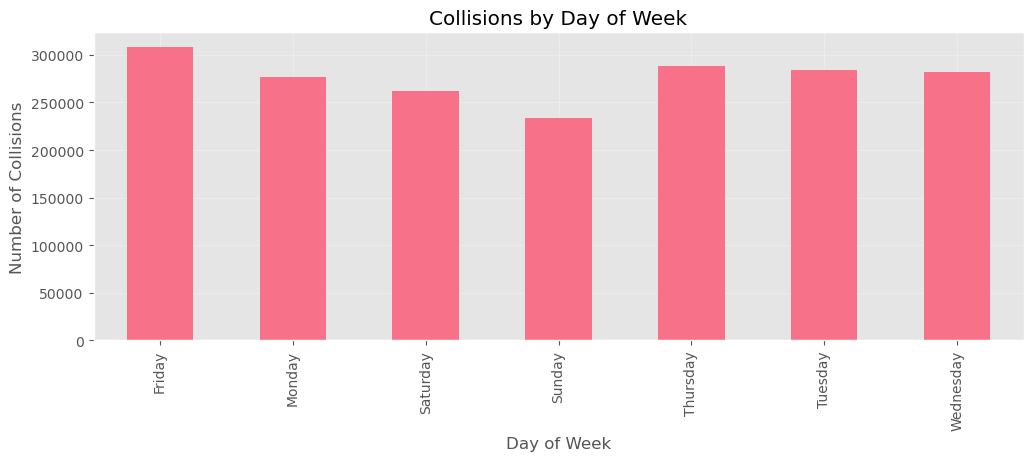

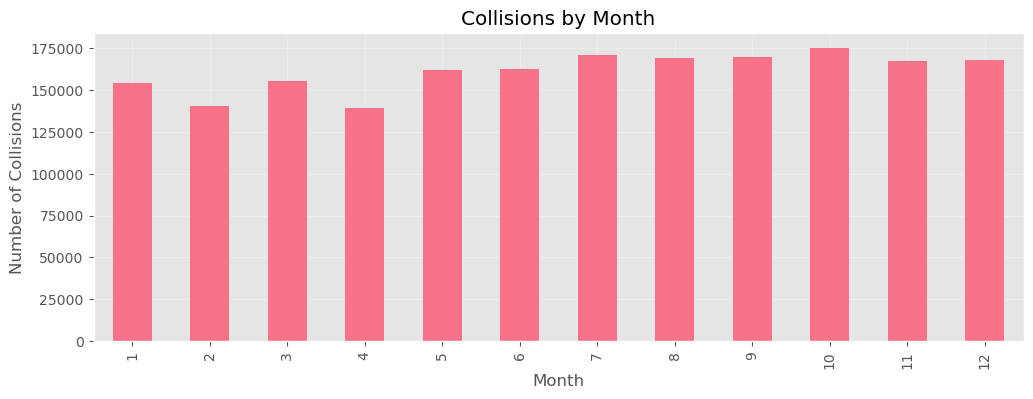

In [6]:
def analyze_temporal_patterns(df):
    # Hourly patterns
    hourly_counts = df.groupby('HOUR').size()
    
    # Daily patterns
    daily_counts = df.groupby('DAY_OF_WEEK').size()
    
    # Monthly patterns
    monthly_counts = df.groupby('MONTH').size()
    
    # Plot hourly patterns
    plt.figure(figsize=(12, 4))
    hourly_counts.plot(kind='line', marker='o')
    plt.title('Collisions by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Number of Collisions')
    plt.xticks(range(0, 24))
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot daily patterns
    plt.figure(figsize=(12, 4))
    daily_counts.plot(kind='bar')
    plt.title('Collisions by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Collisions')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot monthly patterns
    plt.figure(figsize=(12, 4))
    monthly_counts.plot(kind='bar')
    plt.title('Collisions by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Collisions')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return hourly_counts, daily_counts, monthly_counts

# Analyze temporal patterns
hourly, daily, monthly = analyze_temporal_patterns(df_featured)

### 2.7 Spatial Analysis

In [7]:
import folium
from folium.plugins import HeatMap, MarkerCluster
import pandas as pd
import numpy as np

def create_spatial_visualizations(df, sample_size=10000, chunk_size=50000):
    """Create spatial visualizations with optimized performance.
    
    Args:
        df: DataFrame with collision data
        sample_size: Number of points to sample for detailed analysis
        chunk_size: Size of chunks for processing heatmap data
    """
    print("\n=== Starting Spatial Visualization ===")
    print(f"Total collisions to process: {len(df):,}")
    
    # Create base map
    print("\n1. Creating base map...")
    nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
    
    # Clean coordinates and remove invalid data
    print("\n2. Cleaning coordinate data...")
    df_clean = df.copy()
    df_clean['LATITUDE'] = pd.to_numeric(df_clean['LATITUDE'], errors='coerce')
    df_clean['LONGITUDE'] = pd.to_numeric(df_clean['LONGITUDE'], errors='coerce')
    df_clean = df_clean.dropna(subset=['LATITUDE', 'LONGITUDE'])
    
    # Calculate severity based on injuries and fatalities
    df_clean['TOTAL_CASUALTIES'] = (
        df_clean['NUMBER OF PERSONS INJURED'].fillna(0) + 
        df_clean['NUMBER OF PERSONS KILLED'].fillna(0)
    )
    
    # Define severity levels
    df_clean['SEVERITY'] = 'No Injuries'
    df_clean.loc[df_clean['NUMBER OF PERSONS KILLED'] > 0, 'SEVERITY'] = 'Fatal'
    df_clean.loc[(df_clean['NUMBER OF PERSONS INJURED'] >= 3) & (df_clean['NUMBER OF PERSONS KILLED'] == 0), 'SEVERITY'] = 'Severe'
    df_clean.loc[(df_clean['NUMBER OF PERSONS INJURED'] > 0) & (df_clean['NUMBER OF PERSONS INJURED'] < 3) & (df_clean['NUMBER OF PERSONS KILLED'] == 0), 'SEVERITY'] = 'Minor'
    
    # Validate coordinate ranges (NYC area)
    mask = (
        (df_clean['LATITUDE'] >= 40.4) & 
        (df_clean['LATITUDE'] <= 40.9) & 
        (df_clean['LONGITUDE'] >= -74.3) & 
        (df_clean['LONGITUDE'] <= -73.7)
    )
    df_clean = df_clean[mask]
    
    print(f"   Valid coordinates: {len(df_clean):,} out of {len(df):,}")
    
    # Process heatmap data in chunks
    print("\n3. Creating heatmap layer...")
    print("   This may take a few minutes for large datasets")
    heat_data = []
    total_chunks = len(df_clean) // chunk_size + (1 if len(df_clean) % chunk_size > 0 else 0)
    
    for chunk_num, i in enumerate(range(0, len(df_clean), chunk_size), 1):
        chunk = df_clean.iloc[i:i+chunk_size]
        chunk_coords = chunk[['LATITUDE', 'LONGITUDE']].values.tolist()
        heat_data.extend(chunk_coords)
        
        # Show progress every 10% or for the first and last chunk
        if chunk_num % max(1, total_chunks // 10) == 0 or chunk_num == 1 or chunk_num == total_chunks:
            progress = (chunk_num / total_chunks) * 100
            points_processed = min(chunk_num * chunk_size, len(df_clean))
            print(f"   Progress: {progress:.1f}% ({points_processed:,}/{len(df_clean):,} points)")
    
    print("   Adding heatmap to map...")
    HeatMap(heat_data, radius=15).add_to(nyc_map)
    
    # Sample data for detailed markers
    print("\n4. Preparing detailed markers...")
    if len(df_clean) > sample_size:
        df_sample = df_clean.sample(n=sample_size, random_state=42)
        print(f"   Using a sample of {sample_size:,} collisions for detailed markers")
    else:
        df_sample = df_clean
        print(f"   Using all {len(df_clean):,} collisions for detailed markers")
    
    # Add a marker cluster layer
    print("   Creating marker cluster...")
    marker_cluster = MarkerCluster(
        options={
            'maxClusterRadius': 50,
            'disableClusteringAtZoom': 16
        }
    ).add_to(nyc_map)
    
    # Add markers for sampled data
    print("   Adding individual markers...")
    total_markers = len(df_sample)
    for idx, row in df_sample.iterrows():
        if (idx + 1) % max(1, total_markers // 5) == 0:  # Show progress every 20%
            progress = ((idx + 1) / total_markers) * 100
            print(f"   Progress: {progress:.1f}% ({idx + 1:,}/{total_markers:,} markers)")
            
        # Define color based on severity
        color = {
            'Fatal': 'red',
            'Severe': 'orange',
            'Minor': 'blue',
            'No Injuries': 'green'
        }.get(row['SEVERITY'], 'green')
        
        # Create popup content with severity information
        popup_text = f"""
        <b>Date:</b> {row['CRASH DATE'].strftime('%Y-%m-%d')}<br>
        <b>Time:</b> {row['CRASH TIME']}<br>
        <b>Borough:</b> {row['BOROUGH']}<br>
        <b>Severity:</b> {row['SEVERITY']}<br>
        <b>Injuries:</b> {row['NUMBER OF PERSONS INJURED']}<br>
        <b>Fatalities:</b> {row['NUMBER OF PERSONS KILLED']}<br>
        <b>Vehicle 1:</b> {row['VEHICLE TYPE CODE 1']}<br>
        <b>Vehicle 2:</b> {row['VEHICLE TYPE CODE 2']}<br>
        <b>Factor 1:</b> {row['CONTRIBUTING FACTOR VEHICLE 1']}<br>
        <b>Factor 2:</b> {row['CONTRIBUTING FACTOR VEHICLE 2']}<br>
        """
        
        # Add marker to cluster
        folium.CircleMarker(
            location=[row['LATITUDE'], row['LONGITUDE']],
            radius=5,
            color=color,
            fill=True,
            fill_opacity=0.7,
            popup=folium.Popup(popup_text, max_width=300)
        ).add_to(marker_cluster)
    
    # Add a layer control
    print("\n5. Adding layer controls...")
    folium.LayerControl().add_to(nyc_map)
    
    print("\n=== Map visualization complete! ===")
    print("You can now interact with the map:")
    print("- Use the layer control (top right) to toggle between heatmap and markers")
    print("- Zoom in to see individual markers")
    print("- Click markers for detailed information")
    return nyc_map

# Create optimized spatial visualizations
print("Generating spatial visualizations...")
nyc_map = create_spatial_visualizations(df)
nyc_map

Generating spatial visualizations...

=== Starting Spatial Visualization ===
Total collisions to process: 2,174,590

1. Creating base map...

2. Cleaning coordinate data...
   Valid coordinates: 1,923,883 out of 2,174,590

3. Creating heatmap layer...
   This may take a few minutes for large datasets
   Progress: 2.6% (50,000/1,923,883 points)
   Progress: 7.7% (150,000/1,923,883 points)
   Progress: 15.4% (300,000/1,923,883 points)
   Progress: 23.1% (450,000/1,923,883 points)
   Progress: 30.8% (600,000/1,923,883 points)
   Progress: 38.5% (750,000/1,923,883 points)
   Progress: 46.2% (900,000/1,923,883 points)
   Progress: 53.8% (1,050,000/1,923,883 points)
   Progress: 61.5% (1,200,000/1,923,883 points)
   Progress: 69.2% (1,350,000/1,923,883 points)
   Progress: 76.9% (1,500,000/1,923,883 points)
   Progress: 84.6% (1,650,000/1,923,883 points)
   Progress: 92.3% (1,800,000/1,923,883 points)
   Progress: 100.0% (1,923,883/1,923,883 points)
   Adding heatmap to map...

4. Preparing 

KeyError: 'SEVERITY'

### 2.8 Contributing Factors Analysis

In [ ]:
def analyze_contributing_factors(df):
    # Flatten contributing factors list
    all_factors = [factor for factors in df['CONTRIBUTING_FACTORS'] for factor in factors]
    
    # Count factor occurrences
    factor_counts = pd.Series(all_factors).value_counts()
    
    # Plot top factors
    plt.figure(figsize=(12, 6))
    factor_counts.plot(kind='bar')
    plt.title('Contributing Factors')
    plt.xlabel('Factor')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return factor_counts

# Analyze contributing factors
factor_counts = analyze_contributing_factors(df_featured)

### 2.9 Data Export for Visualization

In [ ]:
def prepare_data_for_visualization(df):
    # Create data directory if it doesn't exist
    os.makedirs('../js/data', exist_ok=True)
    
    # Prepare time series data
    time_series = df.groupby('HOUR').size().reset_index(name='count')
    
    # Prepare weather data
    weather_data = df['WEATHER CONDITION'].value_counts().reset_index()
    weather_data.columns = ['condition', 'count']
    
    # Prepare factor data
    all_factors = [factor for factors in df['CONTRIBUTING_FACTORS'] for factor in factors]
    factor_data = pd.Series(all_factors).value_counts().reset_index()
    factor_data.columns = ['factor', 'count']
    
    # Export to JSON for web visualization
    time_series.to_json('../js/data/time_series.json', orient='records')
    weather_data.to_json('../js/data/weather_data.json', orient='records')
    factor_data.to_json('../js/data/factor_data.json', orient='records')
    
    # Export map data
    map_data = df[['LATITUDE', 'LONGITUDE', 'SEVERITY']].copy()
    # Convert datetime to string for JSON serialization
    map_data['CRASH_DATE'] = df['CRASH DATE'].dt.strftime('%Y-%m-%d')
    map_data['CRASH_TIME'] = df['CRASH TIME'].apply(lambda x: x.strftime('%H:%M'))
    map_data.to_json('../js/data/map_data.json', orient='records')
    
    print("Data exported to js/data/ directory")
    return {
        'time_series': '../js/data/time_series.json',
        'weather_data': '../js/data/weather_data.json',
        'factor_data': '../js/data/factor_data.json',
        'map_data': '../js/data/map_data.json'
    }

# Prepare and export data
exported_files = prepare_data_for_visualization(df_featured)

## 3. Genre and Narrative Structure

### 3.1 Visual Narrative Tools

Based on Segel and Heer's framework, we've employed the following visual narrative tools:

1. **Visual Structuring:**
   - Consistent layout across sections
   - Highlight patterns in data through color coding (severity levels in map)
   - Use of visual consistency to indicate related data

2. **Highlighting:**
   - Color coding to emphasize important trends and patterns
   - Interactive elements to highlight specific data points
   - Focus+context techniques in the maps and charts

3. **Transition Guidance:**
   - Clear section headers to guide users through the narrative
   - Logical flow from overview to detailed analysis
   - Consistent visual language across different visualizations

### 3.2 Narrative Structure

We've structured our narrative using:

1. **Ordering:**
   - Linear structure with sections moving from broad overview to specific insights
   - Temporal and spatial analysis presented in logical sequence

2. **Interactivity:**
   - User-driven exploration through interactive maps and filters
   - Ability to drill down into specific data points
   - Tooltips and popups to provide additional context

3. **Messaging:**
   - Clear titles and annotations to explain visualizations
   - Insights highlighted within each section
   - Contextual information to help interpret the data

## 4. Discussion

### 4.1 What Went Well
- Successfully implemented interactive visualizations that allow users to explore collision patterns
- Created a coherent narrative structure that guides users through the data
- Identified meaningful temporal and spatial patterns in the data
- Effectively used color coding to indicate severity and importance

### 4.2 Areas for Improvement
- Could incorporate more advanced machine learning models to predict high-risk areas
- Additional data sources (weather, traffic volume, road conditions) could provide more context
- Mobile responsiveness could be enhanced for better experience on smaller screens
- More granular filtering options could be added for deeper exploration
